In [14]:
%matplotlib inline

#泊松回归和非正常损失
这个例子说明了对数线性泊松回归在“法国汽车第三方责任索赔数据集”上的使用
<https://www.openml.org/d/41214>` _从[1]_比较，与线性模型拟合了通常的最小二乘误差和非线性GBRT模型拟合了泊松损失(和对数链接)。
一些定义:
- **保单**是保险公司和个人之间的合同，个人是**保单持有人**，即本例中的车辆司机。
- **索赔**是指保单持有人要求保险公司赔偿保险所涵盖的损失。
- **风险**是给定保单的保险期限，以年为单位。
-索赔**频率**是索赔数量除以暴露程度，通常以每年索赔数量衡量。
在此数据集中，每个示例都对应于一个保险单。可用的功能包括司机年龄、车辆年龄、车辆功率等。

我们的目标是在给定的历史数据中预测一个新投保人在车祸后的预期索赔频率。
．． [1] A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor，
《案例研究:法国汽车第三方责任索赔》(2018年11月8日)。doi: 10.2139 / ssrn.3164764
<http://dx.doi.org/10.2139/ssrn.3164764>



In [15]:
# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## The French Motor Third-Party Liability Claims dataset

Let's load the motor claim dataset from OpenML:
https://www.openml.org/d/41214



In [16]:
from sklearn.datasets import fetch_openml


df = fetch_openml(data_id=41214, as_frame=True).frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


In [30]:
df.to_excel("./file/Claims.xlsx", sheet_name="Claims", index=False)

11111111111


In [31]:
df.to_csv("././file/claims.cvs")

声明的数量(“ClaimNb”)是一个正整数，可以建模为泊松分布。
然后假设它是在给定时间间隔内以恒定速率发生的离散事件的数量(“曝光”，以年为单位)。
在这里，我们希望通过一个(缩放的)泊松分布对频率'' y = ClaimNb / Exposure ''
有条件地对'' X '''建模，并使用'' Exposure '''作为'' sample_weight ''。

Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


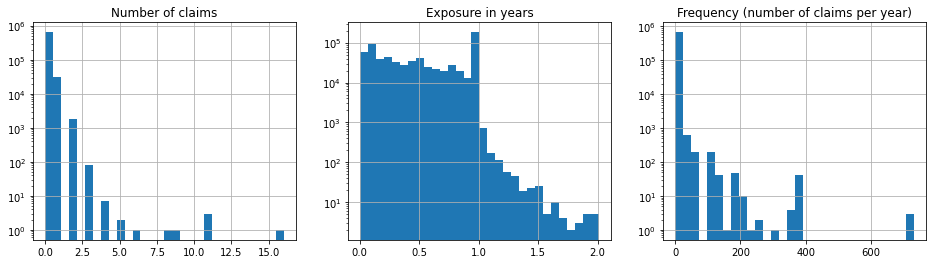

In [18]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

其余列可用于预测索赔事件的频率。
这些列混杂着不同规模的分类变量和数值变量，可能分布非常不均匀。
为了使线性模型与这些预测器相匹配，因此有必要执行以下标准特征转换:


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

##不变的预测基线
值得注意的是，超过93%的投保人没有索赔。如果我们将这个问题转化为一个二元分类任务，
它将是非常不平衡的，即使是一个简单的模型，只预测平均值，可以达到93%的准确率。
为了评估所使用的指标的相关性，我们将考虑一个“虚拟”估计器作为基线，它不断预测训练样本的平均频率。



In [20]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

让我们用3来计算恒定预测基线的性能
不同的回归指标:



In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """对测试集上的估计量进行评分."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    #忽略非积极的预测，因为它们是无效的
    #泊松偏差。
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


##(广义)线性模型
我们首先用(l2惩罚)最小二乘线性回归模型建模目标变量，更常见的是被称为岭回归。
我们使用了较低的惩罚“alpha”，因为我们认为这样的线性模型不适合于如此大的数据集。



In [22]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

泊松偏差不能在模型预测的非正值上计算。对于确实返回了一些非积极预测的模型(例如。
:class: ' ~sklearn.linear_model.Ridge ')忽略相应的样本，
意味着所得到的泊松偏差是近似的。另一种方法可以使用:class:`~ sklearn.compose.transformmedtargetregressor `
将' ' y_pred ' '映射到严格正域的元估计器。

In [23]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.187
mean Poisson deviance: 0.599


然后将泊松回归方程拟合到目标变量上。我们设置了
正则化强度“alpha”到大约1e-6除以数
(即样品。“1e-12”)，以模拟Ridge回归者的L2处罚
随着样本的数量不同，术语的规模也不同。
由于泊松回归在内部模拟了预期目标的对数
值而不是直接的期望值(log vs identity link函数)，
X和y之间的关系不再是线性的。因此,
泊松回归器被称为广义线性模型(GLM)，而不是广义线性模型
普通的线性模型，就像山脊回归一样。


In [24]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


##梯度增强回归树的泊松回归

最后，我们将考虑一个非线性模型，即梯度增强回归树。基于树的模型不需要对类别数据进行一次性编码:相反，
我们可以使用:class:`~sklearn.预处理. ordinalencoder `对每个类别标签进行任意整数编码。
用这个编码时，树会将分类特征视为有序特征，
这可能并不总是一个期望的行为。然而，这种效果是有限的足够深的树，能够恢复分类性质的特征。主要的优点是
:类:“~ sklearn.preprocessing。OrdinalEncoder”在
:类:“~ sklearn.preprocessing。“OneHotEncoder”会让训练变得更快。
梯度增强还提供了一种可能性，拟合树与泊松损失(与一个隐式的对数-链接函数)，而不是默认的最小二乘损失。
这里我们只适合树的泊松损失，以保持这个例子的简洁。



In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.567
MAE: 0.184
mean Poisson deviance: 0.576


像上面的泊松GLM一样，梯度增强树模型最小化了泊松偏差。
但由于具有较高的预测能力，其泊松偏差值较低。
用单一的列车/测试分割来评估模型容易受到随机波动的影响。如果计算资源允许，
应该验证交叉验证的性能指标是否会得出类似的结论。
通过比较观测目标值直方图和预测值直方图，也可以看出这些模型之间的定性差异:



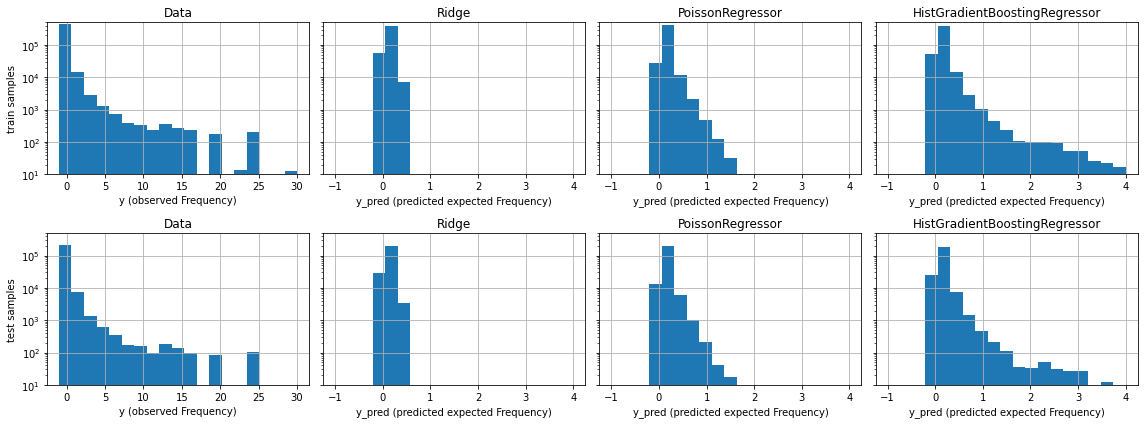

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

实验数据显示' ' y ' '呈长尾分布。在所有模型中，我们预测一个随机变量的预期频率，
所以我们必然会有比观察到的那个随机变量实现更少的极端值。这说明模型预测的直方图的模态不一定对应于最小值。
此外，在“Ridge”中使用的正态分布有一个恒定的方差，
而在“Poisson regression”和“histgradientboostingregression”中使用的泊松分布，方差与预测期望值。
因此，在考虑的估计量中，“poisson regression”和“histgradientboostingregression”
先验地更适合于对非负数据的长尾分布进行建模，而“Ridge”模型对目标变量的分布做出了错误的假设。
' ' histgradientboostingregression ' '估计器具有最大的灵活性，能够预测更高的期望值。
注意，我们本可以将最小二乘损失用于“histgradientboostingregression””模型。
这将错误地假设一个正态分布的响应变量，就像“Ridge”模型一样,也会导致一些负面的预测。
然而，梯度增强树仍然表现得相对较好，特别是优于“泊松回归”，这是由于树的灵活性与大量的训练样本相结合。
##评估校准预测
为了确保估计器对不同的投保人类型产生合理的预测，我们可以根据每个模型返回的' ' y_pred ' '对样本进行测试。然后对每个bin，我们比较预测的平均值' ' y_pred ' '，
平均观测目标:



Actual number of claims: 11935.0
Predicted number of claims by Ridge(alpha=1e-06): 11940.4
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 11939.6
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12216.8
Predicted number of claims by DummyRegressor(): 11931.2


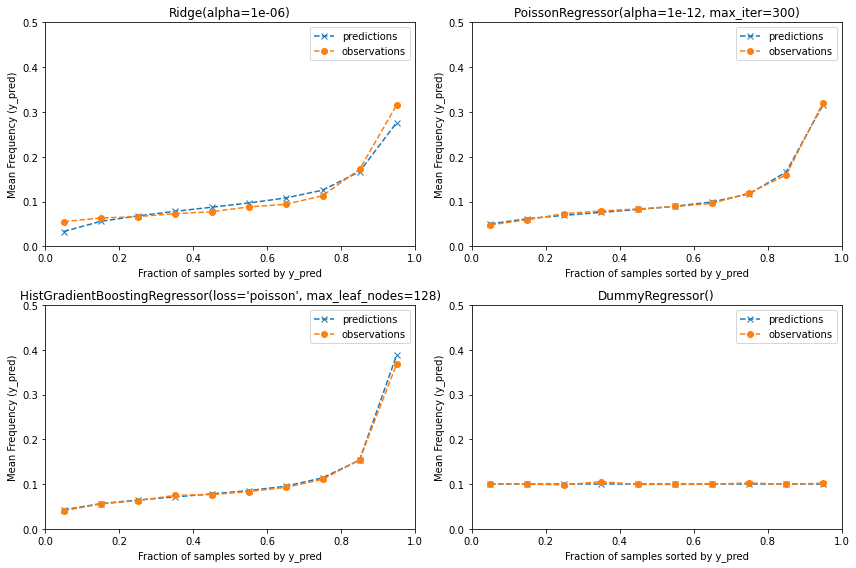

In [27]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

虚拟回归模型预测一个恒定的频率。
这个模型并没有把所有样本都归为相同的并列等级，但是在全球范围内进行了良好的校准(以估计整个总体的平均频率)。
“山脊”回归模型可以预测与数据不匹配的非常低的预期频率。因此，它可能严重低估了一些投保人的风险。
“泊松回归”和“histgradientboostingregression”在预测目标和观测目标之间表现出更好的一致性，特别是对于低预测目标值。
所有预测的总和也证实了“山脊”模型的校准问题:它低估了测试集中索赔总数的3%以上，而其他三个模型可以大致恢复
测试组合的请求总数。
##评价排名权力
对于一些业务应用程序，我们感兴趣的是模型从最安全的投保人中对风险最大的投保人进行排序的能力，
不管预测的绝对值是多少。在这种情况下，模型评估将把问题作为一个排序问题而不是一个回归问题。
为了从这个角度比较这3个模型，我们可以通过模型预测来绘制测试样本顺序的索赔累积比例与暴露累积比例，
根据每个模型从最安全到最危险。
这条曲线被称为洛伦兹曲线，可以用基尼指数来概括:

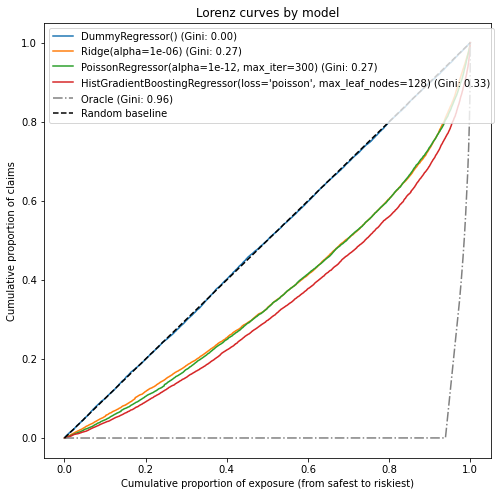

In [28]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")

正如预期的那样，虚拟回归器无法正确地对样本进行排序，因此在这个图中表现最差。
基于树的模型在按风险对保单持有人进行排序方面显著优于两个线性模型。
这三种模型都比概率好得多，但也远远不能做出完美的预测。
最后一点是可以预见的，因为问题的性质:事故的发生主要是由环境原因主导的，
这些原因在数据集的列中没有捕捉到，并且确实可以被认为是纯粹随机的。
线性模型假设输入变量之间没有交互作用，这可能导致欠拟合。
插入一个多项式特征提取器(:func: ' ~sklearn.预处理。多项式特征')确实增加了2点的基尼指数的分辨能力。
特别是，它提高了模型识别前5%风险最高的概况的能力。

##主要收获

-模型的性能可以通过其产生校准良好的预测和良好的排名的能力来评估。
-模型的校准可以通过绘制按预测风险分类的测试样本组的平均观测值和平均预测值来评估。
- Ridge回归模型的最小二乘损失(以及隐含的身份链接函数的使用)似乎导致了这个模型的校准不当。
- 特别是，它倾向于低估风险，甚至可以预测无效的负频率。
-使用泊松损失和日志链接可以纠正这些问题，并得到一个校准良好的线性模型。
-基尼指数反映了一个模型对预测进行排序的能力，而不考虑其绝对值，因此只评估它们的排名能力。
-尽管在校准方面有所改进，但两种线性模型的排序能力相当，且远低于梯度增强回归树的排序能力。
-泊松偏差作为评估指标计算，反映了模型的校准和排名能力。它还对期望值与响应变量方差之间的理想关系作了线性假设。
- 为了简洁起见，我们没有检验这个假设是否成立。
-传统的回归指标，如平均平方误差和平均绝对误差，很难有意义地解释有许多零的计数值。


In [29]:
plt.show()